In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from IPython import display
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

pd.set_option("display.max_columns", None)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [409]:
df = pd.read_csv('diabetes.csv')#.drop('Zodiac', axis = 1)
def toDummy(df, var):
    df = df.join(pd.get_dummies(df[var], prefix= var)).drop(var, axis = 1)
    return df
#df = df.join(pd.get_dummies(df['Zodiac'], prefix='Zodiac')).drop('Zodiac', axis = 1)
df = toDummy(df, 'Zodiac')
df = toDummy(df, 'BiologicalSex')
df = toDummy(df, 'AgeBracket')
df = toDummy(df, 'EducationBracket')
df = toDummy(df, 'IncomeBracket')
y = df['Diabetes']
X = df.iloc[:, 1:]
X = torch.tensor(X.values)
y = torch.tensor(y.values)
X = X.type(torch.FloatTensor)

N = len(df.columns) - 1

## Q1: Perceptron

In [420]:
from sklearn.linear_model import Perceptron
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state=41)
pc = Perceptron()
pc.fit(XTrain, yTrain)
pc._predict_proba_lr(XTest)
pred = pc._predict_proba_lr(XTest)[:,1]
pcAuc = roc_auc_score(yTest, pred)
pcAuc
# RS 628: 0.7657
# 42: 0.5312
# 41: 0.7875

0.7874833877596717

In [418]:
pc = Perceptron()
# first see average CV score
pcAuc = cross_val_score(pc, X, y, scoring = 'roc_auc')
pcAuc.mean()

0.7891975713392723

## Q2 Models and Functions

In [98]:
class Data(Dataset):
    def __init__(self, d):
        self.x = d.type(torch.FloatTensor)[:, 1:]
        self.y = d[:, 0]
        self.numSample = d.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.numSample

def getLoaders(r):
    train, test = train_test_split(torch.tensor(df.values), test_size = 0.4, random_state=r)
    test, val = train_test_split(test, test_size=0.5, random_state=r)
    #est, val = train_test_split(test, test_size = 0.4, random_state=42)
    trainSet = Data(train)
    trainloader = DataLoader(dataset=trainSet,batch_size=200, shuffle=True)
    testSet = Data(test)
    testloader = DataLoader(dataset=testSet,batch_size=2000, shuffle=True)
    valSet = Data(val)
    valoader = DataLoader(dataset=valSet,batch_size=2000, shuffle=True)
    return trainloader, testloader, valoader


def TRAIN(epoch, model,lossF, train_loader):
    model.train()
    losses = []
    auc = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    for DD in train_loader:
        data, target = DD
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        #data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        try:
            auc.append(roc_auc_score(target, output.detach().numpy()))
        except:
            pass
        loss = lossF(output, target.unsqueeze(1).type(torch.FloatTensor))
        losses.append(loss.item())
        # backward pass through the cross-entropy loss function and the model
        loss.backward()
        
        optimizer.step()
    print('[EPOCH %d]\t[TRAIN LOSS]: %f\t[TRAIN AUC]: %f' % (epoch,np.mean(losses), np.mean(auc)))
    return np.mean(losses), np.mean(auc)


def TEST(model,lossF, train_loader):
    model.eval()
    losses = []
    auc = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)
            # forward pass through the model
            output = model(data)
            # forward pass through the cross-entropy loss function
            try:
                auc.append(roc_auc_score(target, output.detach().numpy()))
            except:
                pass
            loss = lossF(output, target.unsqueeze(1).type(torch.FloatTensor))
            losses.append(loss.item())
            # backward pass through the cross-entropy loss function and the model

        print('[TEST LOSS AVG]: %f\t[TEST AUC AVG]: %f' % (np.mean(losses), np.mean(auc)))
    return np.mean(losses), np.mean(auc)


hiddensize = 50
h = hiddensize
NN1Relu = nn.Sequential(
            nn.Linear(N, hiddensize),
            nn.ReLU(),
            nn.Linear(hiddensize, 1),
            nn.Sigmoid()
)



NN2Relu = nn.Sequential(
            nn.Linear(N, hiddensize),
            nn.ReLU(),
            nn.Linear(hiddensize, hiddensize),
            nn.ReLU(),
            nn.Linear(hiddensize, 1),
            nn.Sigmoid()
)

NN3Relu = nn.Sequential(
            nn.Linear(N, hiddensize),
            nn.ReLU(),
            nn.Linear(hiddensize, hiddensize),
            nn.ReLU(),
            nn.Linear(hiddensize, hiddensize),
            nn.ReLU(),
            nn.Linear(hiddensize, 1),
            nn.Sigmoid()
)



NN1Sig = nn.Sequential(
            nn.Linear(N, h),
            nn.Sigmoid(),
            nn.Linear(h, 1),
            nn.Sigmoid()
)



NN2Sig = nn.Sequential(
            nn.Linear(N, h),
            nn.Sigmoid(),
            nn.Linear(h, h),
            nn.Sigmoid(),
            nn.Linear(h, 1),
            nn.Sigmoid()
)
NN3Sig = nn.Sequential(
            nn.Linear(N, h),
            nn.Sigmoid(),
            nn.Linear(h, h),
            nn.Sigmoid(),
            nn.Linear(h, h),
            nn.Sigmoid(),
            nn.Linear(h, 1),
            nn.Sigmoid()
)

NN1 = nn.Sequential(
            nn.Linear(N, h),
            nn.Linear(h, 1),
            nn.Sigmoid()
)


NN0 = nn.Sequential(
            nn.Linear(N, 1),
            nn.Sigmoid()
)
NN2 = nn.Sequential(
            nn.Linear(N, h),
            nn.Linear(h, h),
            nn.Linear(h, 1),
            nn.Sigmoid()
)
NN3 = nn.Sequential(
            nn.Linear(N, h),
            nn.Linear(h, h),
            nn.Linear(h, h),
            nn.Linear(h, 1),
            nn.Sigmoid()

)

Q2Dic = {'NN1':NN1, 'NN2':NN2, 'NN3':NN3, 'NN1Relu':NN1Relu, 'NN1Sig':NN1Sig, 'NN1Relu':NN1Relu, 'NN2Sig':NN2Sig, 'NN3Sig':NN3Sig, 'NN2Relu': NN2Relu, 'NN3Relu': NN3Relu}
#temp = sorted(Q2Dic.keys())


trainloader, testloader, valloader = getLoaders(42)

### Build and train a feedforward neural network with at least one hidden layer to classify diabetes from the rest of the dataset. Make sure to try different numbers of hidden layers and different activation functions (at a minimum reLU and sigmoid). Doing so: How does AUC vary as a function of the number of hidden layers and is it dependent on the kind of activation function used (make sure to include “no activation function” in your comparison). How does this network perform relative to the Perceptron? 

In [72]:
bce = nn.BCELoss()
bcelogit = nn.BCEWithLogitsLoss()
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NN1Relu.parameters(), lr=1e-3, weight_decay=1e-3)
def compareTrainTest(model, numEpoch, graph):
    trainStats = np.empty([numEpoch, 2])*np.nan
    testStats = np.empty([numEpoch, 2])*np.nan
    for ii in range(1, numEpoch + 1):
        trainStats[ii-1][0], trainStats[ii-1][1] = TRAIN(ii, model, bce, trainloader)
        testStats[ii-1][0], testStats[ii-1][1] = TEST(model, bce, testloader)
    if graph:
        plt.figure(figsize=(10,6))
        plt.plot(trainStats[:,0], color = 'blue')
        plt.plot(testStats[:,0], color = 'orange')
        plt.legend(['train','test'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.figure(figsize=(10,6))
        plt.plot(trainStats[:,1], color = 'blue')
        plt.plot(testStats[:,1], color = 'orange')
        plt.legend(['train','test'])
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
    return trainStats, testStats


In [73]:
train, test = compareTrainTest(NN1Relu, 20, True)

[EPOCH 1]	[TRAIN LOSS]: 0.355610	[TRAIN AUC]: 0.738389
[TEST LOSS AVG]: 0.329188	[TEST AUC AVG]: 0.806148
[EPOCH 2]	[TRAIN LOSS]: 0.328366	[TRAIN AUC]: 0.810716
[TEST LOSS AVG]: 0.324261	[TEST AUC AVG]: 0.814886
[EPOCH 3]	[TRAIN LOSS]: 0.323750	[TRAIN AUC]: 0.816862
[TEST LOSS AVG]: 0.321894	[TEST AUC AVG]: 0.820159


KeyboardInterrupt: 

In [6]:
aucDf = pd.DataFrame(columns = ['Loss','AUC'])

In [74]:
rs = [42, 68, 128]
for z in rs:
    trainloader, testloader, valloader = getLoaders(z)
    for ii in Q2Dic.keys():
        print('Training %s' % ii)
        model = Q2Dic[ii]
        for jj in range(11):
            TRAIN(jj, model, bce, trainloader)
        temp = TEST(model, bce, valloader)
        aucDf.loc[ii + '_RS_{}'.format(z), 'Loss'] = temp[0]
        aucDf.loc[ii+ '_RS_{}'.format(z), 'AUC'] = temp[1]

Training NN1
[EPOCH 0]	[TRAIN LOSS]: 0.350535	[TRAIN AUC]: 0.757773
[EPOCH 1]	[TRAIN LOSS]: 0.328050	[TRAIN AUC]: 0.812932
[EPOCH 2]	[TRAIN LOSS]: 0.325209	[TRAIN AUC]: 0.817166
[EPOCH 3]	[TRAIN LOSS]: 0.325323	[TRAIN AUC]: 0.818022
[EPOCH 4]	[TRAIN LOSS]: 0.324413	[TRAIN AUC]: 0.818161
[EPOCH 5]	[TRAIN LOSS]: 0.324447	[TRAIN AUC]: 0.818463
[EPOCH 6]	[TRAIN LOSS]: 0.324908	[TRAIN AUC]: 0.819281
[EPOCH 7]	[TRAIN LOSS]: 0.324319	[TRAIN AUC]: 0.818900
[EPOCH 8]	[TRAIN LOSS]: 0.324321	[TRAIN AUC]: 0.819569
[EPOCH 9]	[TRAIN LOSS]: 0.323483	[TRAIN AUC]: 0.819461
[EPOCH 10]	[TRAIN LOSS]: 0.323495	[TRAIN AUC]: 0.819084
[TEST LOSS AVG]: 0.323567	[TEST AUC AVG]: 0.819090
Training NN2
[EPOCH 0]	[TRAIN LOSS]: 0.348735	[TRAIN AUC]: 0.766187
[EPOCH 1]	[TRAIN LOSS]: 0.326895	[TRAIN AUC]: 0.815456
[EPOCH 2]	[TRAIN LOSS]: 0.326004	[TRAIN AUC]: 0.816961
[EPOCH 3]	[TRAIN LOSS]: 0.324436	[TRAIN AUC]: 0.818814
[EPOCH 4]	[TRAIN LOSS]: 0.324236	[TRAIN AUC]: 0.819102
[EPOCH 5]	[TRAIN LOSS]: 0.323847	[TRAIN AU

In [99]:
trainloader, testloader, valloader = getLoaders(42)
z = 42
for ii in ['NN1Sig', 'NN2Sig','NN3Sig']:
    model = Q2Dic[ii]
    for jj in range(11):
        TRAIN(jj, model, bce, trainloader)
    temp = TEST(model, bce, valloader)
    aucDf.loc[ii + '_RS_{}'.format(z), 'Loss'] = temp[0]
    aucDf.loc[ii+ '_RS_{}'.format(z), 'AUC'] = temp[1]

[EPOCH 0]	[TRAIN LOSS]: 0.358396	[TRAIN AUC]: 0.761803
[EPOCH 1]	[TRAIN LOSS]: 0.324618	[TRAIN AUC]: 0.816193
[EPOCH 2]	[TRAIN LOSS]: 0.321387	[TRAIN AUC]: 0.819640
[EPOCH 3]	[TRAIN LOSS]: 0.320439	[TRAIN AUC]: 0.821302
[EPOCH 4]	[TRAIN LOSS]: 0.319769	[TRAIN AUC]: 0.821571
[EPOCH 5]	[TRAIN LOSS]: 0.319973	[TRAIN AUC]: 0.822260
[EPOCH 6]	[TRAIN LOSS]: 0.319682	[TRAIN AUC]: 0.821733
[EPOCH 7]	[TRAIN LOSS]: 0.319210	[TRAIN AUC]: 0.822413
[EPOCH 8]	[TRAIN LOSS]: 0.319250	[TRAIN AUC]: 0.822166
[EPOCH 9]	[TRAIN LOSS]: 0.319335	[TRAIN AUC]: 0.822833
[EPOCH 10]	[TRAIN LOSS]: 0.319100	[TRAIN AUC]: 0.822530
[TEST LOSS AVG]: 0.315164	[TEST AUC AVG]: 0.822066
[EPOCH 0]	[TRAIN LOSS]: 0.373836	[TRAIN AUC]: 0.740122
[EPOCH 1]	[TRAIN LOSS]: 0.326816	[TRAIN AUC]: 0.815932
[EPOCH 2]	[TRAIN LOSS]: 0.323136	[TRAIN AUC]: 0.818505
[EPOCH 3]	[TRAIN LOSS]: 0.322687	[TRAIN AUC]: 0.819643
[EPOCH 4]	[TRAIN LOSS]: 0.321276	[TRAIN AUC]: 0.819832
[EPOCH 5]	[TRAIN LOSS]: 0.321139	[TRAIN AUC]: 0.821081
[EPOCH 6]	[TR

In [89]:
TRAIN(1, NN1Sig, bce, trainloader)

[EPOCH 1]	[TRAIN LOSS]: 0.319375	[TRAIN AUC]: 0.821365


(0.3193751991851123, 0.8213652972485773)

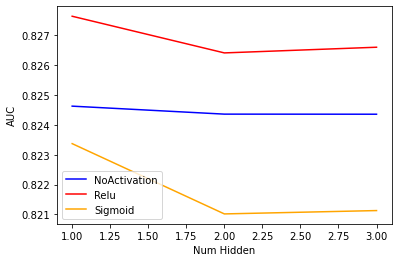

In [244]:
aucDf = aucDf.sort_index()
reluAUCs = aucDf.loc[[x for x in aucDf.index if 'Relu' in x and '128' in x], 'AUC']
sigAUCs = aucDf.loc[[x for x in aucDf.index if 'Sig' in x and '128' in x], 'AUC']
noActAUCs = aucDf.loc[[x for x in aucDf.index if 'Sig' not in x and 'Relu' not in x and '128' in x], 'AUC']
act = ['NoActivation','Relu','Sigmoid']
plt.plot([1,2,3], noActAUCs[1:], color = 'blue')
plt.plot([1,2,3], reluAUCs, color = 'red')
plt.plot([1,2,3], sigAUCs, color = 'orange')
plt.xlabel('Num Hidden')
plt.ylabel('AUC')
plt.legend(act)


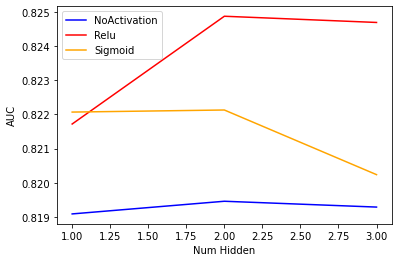

In [245]:
reluAUCs = aucDf.loc[[x for x in aucDf.index if 'Relu' in x and '42' in x], 'AUC']
sigAUCs = aucDf.loc[[x for x in aucDf.index if 'Sig' in x and '42' in x], 'AUC']
noActAUCs = aucDf.loc[[x for x in aucDf.index if 'Sig' not in x and 'Relu' not in x and '42' in x], 'AUC']
act = ['NoActivation','Relu','Sigmoid']
plt.plot([1,2,3], noActAUCs[1:], color = 'blue')
plt.plot([1,2,3], reluAUCs, color = 'red')
plt.plot([1,2,3], sigAUCs, color = 'orange')
plt.xlabel('Num Hidden')
plt.ylabel('AUC')
plt.legend(act)

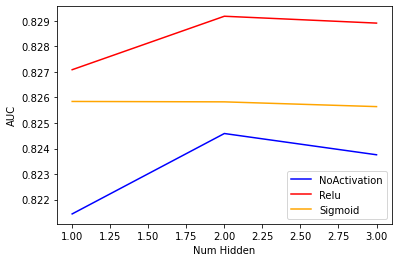

In [246]:
reluAUCs = aucDf.loc[[x for x in aucDf.index if 'Relu' in x and '68' in x], 'AUC']
sigAUCs = aucDf.loc[[x for x in aucDf.index if 'Sig' in x and '68' in x], 'AUC']
noActAUCs = aucDf.loc[[x for x in aucDf.index if 'Sig' not in x and 'Relu' not in x and '68' in x], 'AUC']
act = ['NoActivation','Relu','Sigmoid']
plt.plot([1,2,3], noActAUCs[1:], color = 'blue')
plt.plot([1,2,3], reluAUCs, color = 'red')
plt.plot([1,2,3], sigAUCs, color = 'orange')
plt.xlabel('Num Hidden')
plt.ylabel('AUC')
plt.legend(act)


In [248]:
aucDf.sort_values('AUC', ascending=False)

,Loss,AUC
NN2Relu_RS_68,0.312587,0.829181
NN3Relu_RS_68,0.31286,0.828912
NN1Relu_RS_128,0.314845,0.827644
NN1Relu_RS_68,0.312814,0.827087
NN3Relu_RS_128,0.317991,0.826605
NN2Relu_RS_128,0.316931,0.826414
NN1Sig_RS_68,0.314531,0.825845
NN2Sig_RS_68,0.315231,0.825829
NN3Sig_RS_68,0.315806,0.825643
NN2Relu_RS_42,0.31312,0.824868


## Build and train a “deep” network (at least 2 hidden layers) to classify diabetes from the rest of the dataset. Given the nature of this dataset, is there a benefit of using a CNN or RNN for the classification?

[EPOCH 1]	[TRAIN LOSS]: 0.353513	[TRAIN AUC]: 0.735347
[TEST LOSS AVG]: 0.332902	[TEST AUC AVG]: 0.820983
[EPOCH 2]	[TRAIN LOSS]: 0.321885	[TRAIN AUC]: 0.819742
[TEST LOSS AVG]: 0.320051	[TEST AUC AVG]: 0.823181
[EPOCH 3]	[TRAIN LOSS]: 0.320651	[TRAIN AUC]: 0.821566
[TEST LOSS AVG]: 0.320529	[TEST AUC AVG]: 0.823619
[EPOCH 4]	[TRAIN LOSS]: 0.319539	[TRAIN AUC]: 0.823217
[TEST LOSS AVG]: 0.316503	[TEST AUC AVG]: 0.825951
[EPOCH 5]	[TRAIN LOSS]: 0.319946	[TRAIN AUC]: 0.823314
[TEST LOSS AVG]: 0.316560	[TEST AUC AVG]: 0.824044
[EPOCH 6]	[TRAIN LOSS]: 0.318982	[TRAIN AUC]: 0.823651
[TEST LOSS AVG]: 0.321190	[TEST AUC AVG]: 0.824732
[EPOCH 7]	[TRAIN LOSS]: 0.318112	[TRAIN AUC]: 0.825128
[TEST LOSS AVG]: 0.318566	[TEST AUC AVG]: 0.824134
[EPOCH 8]	[TRAIN LOSS]: 0.318001	[TRAIN AUC]: 0.824759
[TEST LOSS AVG]: 0.316586	[TEST AUC AVG]: 0.826765
[EPOCH 9]	[TRAIN LOSS]: 0.318284	[TRAIN AUC]: 0.825008
[TEST LOSS AVG]: 0.315588	[TEST AUC AVG]: 0.826555
[EPOCH 10]	[TRAIN LOSS]: 0.317853	[TRAIN AUC]:

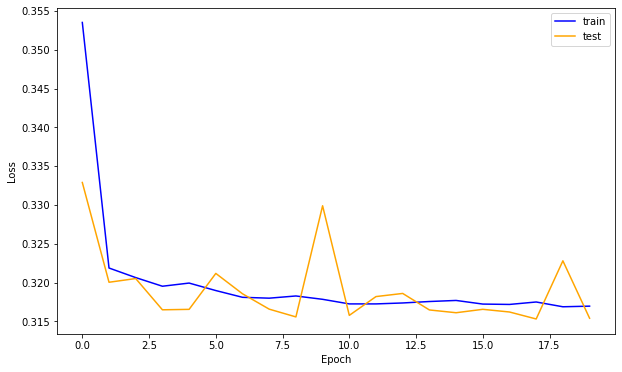

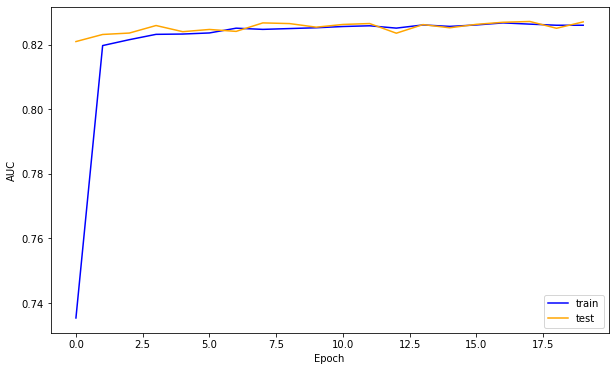

In [111]:
hiddensize = 32
def buildNN4Relu(hiddensize):
    NN4Relu = nn.Sequential(
                nn.Linear(N, hiddensize),
                nn.ReLU(),
                nn.Linear(hiddensize, hiddensize),
                nn.ReLU(),
                nn.Linear(hiddensize, hiddensize),
                nn.ReLU(),
                nn.Linear(hiddensize, hiddensize),
                nn.ReLU(),
                nn.Linear(hiddensize, 1),
                nn.Sigmoid()
    )
    return NN4Relu

NN4ReluCopy = buildNN4Relu(hiddensize)
NN4Relu = buildNN4Relu(hiddensize)
train, test = compareTrainTest(NN4ReluCopy, 20, True)



In [112]:
for ii in range(11):
    TRAIN(ii, NN4Relu, bce, trainloader)

TEST(NN4Relu, bce, valloader)

[EPOCH 0]	[TRAIN LOSS]: 0.354350	[TRAIN AUC]: 0.731549
[EPOCH 1]	[TRAIN LOSS]: 0.321688	[TRAIN AUC]: 0.820176
[EPOCH 2]	[TRAIN LOSS]: 0.320098	[TRAIN AUC]: 0.821464
[EPOCH 3]	[TRAIN LOSS]: 0.320021	[TRAIN AUC]: 0.822275
[EPOCH 4]	[TRAIN LOSS]: 0.319048	[TRAIN AUC]: 0.823544
[EPOCH 5]	[TRAIN LOSS]: 0.319642	[TRAIN AUC]: 0.823718
[EPOCH 6]	[TRAIN LOSS]: 0.319007	[TRAIN AUC]: 0.823847
[EPOCH 7]	[TRAIN LOSS]: 0.318453	[TRAIN AUC]: 0.824086
[EPOCH 8]	[TRAIN LOSS]: 0.318616	[TRAIN AUC]: 0.824372
[EPOCH 9]	[TRAIN LOSS]: 0.318101	[TRAIN AUC]: 0.824871
[EPOCH 10]	[TRAIN LOSS]: 0.318382	[TRAIN AUC]: 0.824715
[TEST LOSS AVG]: 0.313049	[TEST AUC AVG]: 0.825167


(0.3130487192135591, 0.8251665710122206)

## Build and train a feedforward neural network with one hidden layer to predict BMI from the rest of the dataset. Use RMSE to assess the accuracy of your model. Does the RMSE depend on the activation function used?

In [425]:
from sklearn.metrics import mean_squared_error as MSE
first_column = df.pop('BMI')
df.insert(0, 'BMI', first_column)
trainloader, testloader, valloader = getLoaders(42)
def RTRAIN(epoch, model, train_loader):
    lossF = nn.MSELoss()
    model.train()
    losses = []
    auc = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    for DD in train_loader:
        data, target = DD
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        #data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        auc.append(np.sqrt(MSE(target, output.detach().numpy())))
        loss = torch.sqrt(lossF(output, target.unsqueeze(1).type(torch.FloatTensor)))
        losses.append(loss.item())
        # backward pass through the cross-entropy loss function and the model
        loss.backward()
        
        optimizer.step()
    print('[EPOCH %d]\t[TRAIN LOSS]: %f\t[TRAIN RMSE]: %f' % (epoch,np.mean(losses), np.mean(auc)))
    return np.mean(losses), np.mean(auc)


def RTEST(model,train_loader):
    model.eval()
    losses = []
    auc = []
    lossF = nn.MSELoss()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)
            # forward pass through the model
            output = model(data)
            # forward pass through the cross-entropy loss function
            auc.append(np.sqrt(MSE(target, output.detach().numpy())))
            loss = torch.sqrt(lossF(output, target.unsqueeze(1).type(torch.FloatTensor)))
            losses.append(loss.item())
            # backward pass through the cross-entropy loss function and the model

        print('[TEST LOSS AVG]: %f\t[TEST RMSE AVG]: %f' % (np.mean(losses), np.mean(auc)))
    return np.mean(losses), np.mean(auc)


def RcompareTrainTest(model, numEpoch, graph):
    trainStats = np.empty([numEpoch, 2])*np.nan
    testStats = np.empty([numEpoch, 2])*np.nan
    for ii in range(1, numEpoch + 1):
        trainStats[ii-1][0], trainStats[ii-1][1] = RTRAIN(ii, model, trainloader)
        testStats[ii-1][0], testStats[ii-1][1] = RTEST(model, testloader)
    if graph:
        plt.figure(figsize=(10,6))
        plt.plot(trainStats[:,0], color = 'blue')
        plt.plot(testStats[:,0], color = 'orange')
        plt.legend(['train','test'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.figure(figsize=(10,6))
        plt.plot(trainStats[:,1], color = 'blue')
        plt.plot(testStats[:,1], color = 'orange')
        plt.legend(['train','test'])
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
    return trainStats, testStats

In [151]:
def buildNN1Relu(hiddensize):
    NN4Relu = nn.Sequential(
                nn.Linear(N, hiddensize),
                nn.ReLU(),
                nn.Linear(hiddensize, 1),
    )
    return NN4Relu
regre = buildNN1Relu(32)
regreCopy = buildNN1Relu(32)

#_,_ = RcompareTrainTest(regre,20, True )

In [152]:
for ii in range(3):
    RTRAIN(ii, regreCopy, trainloader)
RTEST(regreCopy, valloader)

[EPOCH 0]	[TRAIN LOSS]: 10.676407	[TRAIN RMSE]: 10.676407
[EPOCH 1]	[TRAIN LOSS]: 6.156082	[TRAIN RMSE]: 6.156082
[EPOCH 2]	[TRAIN LOSS]: 6.050491	[TRAIN RMSE]: 6.050491
[TEST LOSS AVG]: 6.000234	[TEST RMSE AVG]: 6.000234


(6.0002339986654425, 6.000234002898558)

[EPOCH 1]	[TRAIN LOSS]: 15.105039	[TRAIN RMSE]: 15.105039
[TEST LOSS AVG]: 7.037788	[TEST RMSE AVG]: 7.037788
[EPOCH 2]	[TRAIN LOSS]: 6.209127	[TRAIN RMSE]: 6.209127
[TEST LOSS AVG]: 6.198828	[TEST RMSE AVG]: 6.198828
[EPOCH 3]	[TRAIN LOSS]: 6.015195	[TRAIN RMSE]: 6.015195
[TEST LOSS AVG]: 6.131312	[TEST RMSE AVG]: 6.131312
[EPOCH 4]	[TRAIN LOSS]: 5.993948	[TRAIN RMSE]: 5.993948
[TEST LOSS AVG]: 6.113732	[TEST RMSE AVG]: 6.113732
[EPOCH 5]	[TRAIN LOSS]: 5.968586	[TRAIN RMSE]: 5.968586
[TEST LOSS AVG]: 6.088867	[TEST RMSE AVG]: 6.088867
[EPOCH 6]	[TRAIN LOSS]: 5.965199	[TRAIN RMSE]: 5.965199
[TEST LOSS AVG]: 6.080589	[TEST RMSE AVG]: 6.080589
[EPOCH 7]	[TRAIN LOSS]: 5.957883	[TRAIN RMSE]: 5.957883
[TEST LOSS AVG]: 6.082027	[TEST RMSE AVG]: 6.082027
[EPOCH 8]	[TRAIN LOSS]: 5.952589	[TRAIN RMSE]: 5.952589
[TEST LOSS AVG]: 6.059408	[TEST RMSE AVG]: 6.059408
[EPOCH 9]	[TRAIN LOSS]: 5.952641	[TRAIN RMSE]: 5.952641
[TEST LOSS AVG]: 6.067423	[TEST RMSE AVG]: 6.067423
[EPOCH 10]	[TRAIN LOSS]: 5

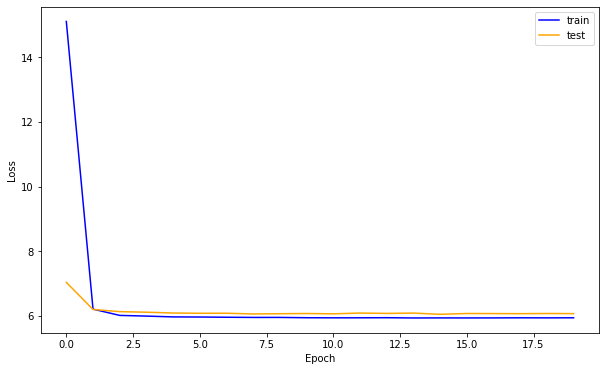

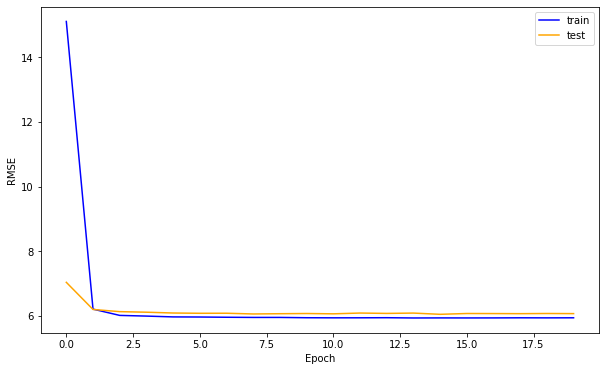

In [143]:
def buildNN1tan(hiddensize):
    NN4Relu = nn.Sequential(
                nn.Linear(N, hiddensize),
                nn.Tanh(),
                nn.Linear(hiddensize, 1),
    )
    return NN4Relu
tan = buildNN1tan(32)
tanCopy = buildNN1tan(32)

_,_ = RcompareTrainTest(tan,20, True )

In [144]:
for ii in range(3):
    RTRAIN(ii, tanCopy, trainloader)
RTEST(tanCopy, valloader)

[EPOCH 0]	[TRAIN LOSS]: 15.431786	[TRAIN RMSE]: 15.431786
[EPOCH 1]	[TRAIN LOSS]: 6.227990	[TRAIN RMSE]: 6.227990
[EPOCH 2]	[TRAIN LOSS]: 6.011057	[TRAIN RMSE]: 6.011057
[TEST LOSS AVG]: 5.942120	[TEST RMSE AVG]: 5.942120


(5.942119910166814, 5.942119967391106)

In [147]:
def buildNN1Sig(hiddensize):
    NN4Relu = nn.Sequential(
                nn.Linear(N, hiddensize),
                nn.Sigmoid(),
                nn.Linear(hiddensize, 1),
    )
    return NN4Relu
sig = buildNN1Sig(32)
sigCopy = buildNN1Sig(32)

#_,_ = RcompareTrainTest(sig,20, True )

In [148]:
for ii in range(3):
    RTRAIN(ii, sigCopy, trainloader)
RTEST(tanCopy, valloader)

[EPOCH 0]	[TRAIN LOSS]: 16.783899	[TRAIN RMSE]: 16.783899
[EPOCH 1]	[TRAIN LOSS]: 6.292445	[TRAIN RMSE]: 6.292445
[EPOCH 2]	[TRAIN LOSS]: 6.053177	[TRAIN RMSE]: 6.053177
[TEST LOSS AVG]: 5.931351	[TEST RMSE AVG]: 5.931351


(5.931351331564096, 5.931351380347748)

## Build and train a neural network of your choice to predict BMI from the rest of your dataset. How low can you get RMSE and what design choices does RMSE seem to depend on?

[EPOCH 1]	[TRAIN LOSS]: 13.097468	[TRAIN RMSE]: 13.097468
[TEST LOSS AVG]: 6.709750	[TEST RMSE AVG]: 6.709750
[EPOCH 2]	[TRAIN LOSS]: 6.525370	[TRAIN RMSE]: 6.525370
[TEST LOSS AVG]: 6.626190	[TEST RMSE AVG]: 6.626190
[EPOCH 3]	[TRAIN LOSS]: 6.204767	[TRAIN RMSE]: 6.204767
[TEST LOSS AVG]: 6.173786	[TEST RMSE AVG]: 6.173786
[EPOCH 4]	[TRAIN LOSS]: 6.049748	[TRAIN RMSE]: 6.049748
[TEST LOSS AVG]: 6.218475	[TEST RMSE AVG]: 6.218475
[EPOCH 5]	[TRAIN LOSS]: 6.056929	[TRAIN RMSE]: 6.056929
[TEST LOSS AVG]: 6.149493	[TEST RMSE AVG]: 6.149493
[EPOCH 6]	[TRAIN LOSS]: 6.027655	[TRAIN RMSE]: 6.027655
[TEST LOSS AVG]: 6.203186	[TEST RMSE AVG]: 6.203186
[EPOCH 7]	[TRAIN LOSS]: 6.019154	[TRAIN RMSE]: 6.019154
[TEST LOSS AVG]: 6.152791	[TEST RMSE AVG]: 6.152791
[EPOCH 8]	[TRAIN LOSS]: 6.018369	[TRAIN RMSE]: 6.018369
[TEST LOSS AVG]: 6.132134	[TEST RMSE AVG]: 6.132134
[EPOCH 9]	[TRAIN LOSS]: 6.004633	[TRAIN RMSE]: 6.004633
[TEST LOSS AVG]: 6.149780	[TEST RMSE AVG]: 6.149780
[EPOCH 10]	[TRAIN LOSS]: 5

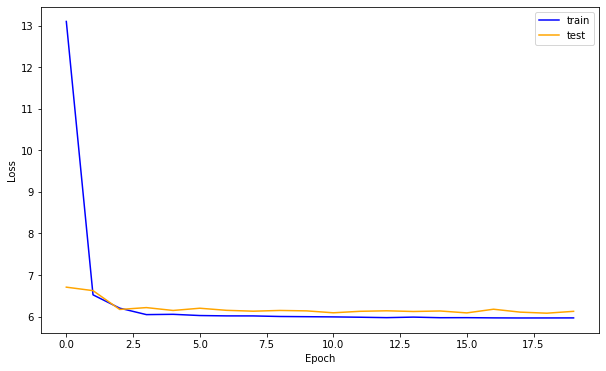

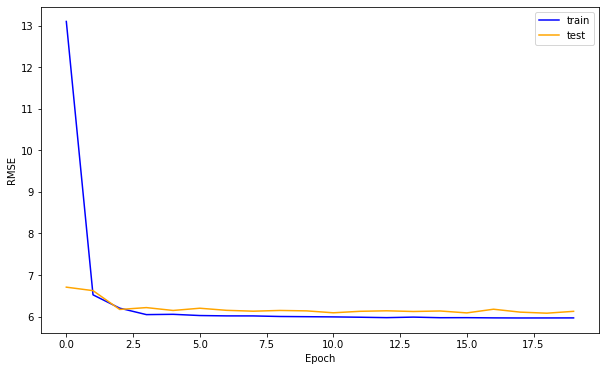

In [426]:
h = 32
def buildregre4(hiddensize):
    NNRelu = nn.Sequential(
                nn.Linear(N, hiddensize),
                nn.Sigmoid(),
                nn.Linear(hiddensize, hiddensize),
                nn.Sigmoid(),
                nn.Linear(hiddensize, hiddensize),
                nn.Sigmoid(),
                nn.Linear(hiddensize, hiddensize),
                nn.Sigmoid(),
                nn.Linear(hiddensize, 1),
    )
    return NNRelu
regre4 = buildregre4(64)
#regre3C = buildregre3(1)
RcompareTrainTest(regre4, 20, True);

In [434]:
regre4C = buildregre4(64)
rmse = []
for ii in range(4):
    RTRAIN(ii, regre4C, trainloader)
    RTEST(regre4C, valloader)
    #rmse.append(RTEST(regre4C, valloader)[1])


[EPOCH 0]	[TRAIN LOSS]: 13.844187	[TRAIN RMSE]: 13.844187
[TEST LOSS AVG]: 6.526042	[TEST RMSE AVG]: 6.526042
[EPOCH 1]	[TRAIN LOSS]: 6.531602	[TRAIN RMSE]: 6.531602
[TEST LOSS AVG]: 6.432680	[TEST RMSE AVG]: 6.432680
[EPOCH 2]	[TRAIN LOSS]: 6.284133	[TRAIN RMSE]: 6.284133
[TEST LOSS AVG]: 6.034210	[TEST RMSE AVG]: 6.034210
[EPOCH 3]	[TRAIN LOSS]: 6.046897	[TRAIN RMSE]: 6.046897
[TEST LOSS AVG]: 5.986804	[TEST RMSE AVG]: 5.986804


[EPOCH 1]	[TRAIN LOSS]: 9.895173	[TRAIN RMSE]: 9.895173
[TEST LOSS AVG]: 6.688717	[TEST RMSE AVG]: 6.688717
[EPOCH 2]	[TRAIN LOSS]: 6.365457	[TRAIN RMSE]: 6.365457
[TEST LOSS AVG]: 6.201161	[TEST RMSE AVG]: 6.201161
[EPOCH 3]	[TRAIN LOSS]: 6.048568	[TRAIN RMSE]: 6.048568
[TEST LOSS AVG]: 6.164957	[TEST RMSE AVG]: 6.164957
[EPOCH 4]	[TRAIN LOSS]: 6.048359	[TRAIN RMSE]: 6.048359
[TEST LOSS AVG]: 6.166826	[TEST RMSE AVG]: 6.166826
[EPOCH 5]	[TRAIN LOSS]: 6.035577	[TRAIN RMSE]: 6.035577
[TEST LOSS AVG]: 6.156103	[TEST RMSE AVG]: 6.156103
[EPOCH 6]	[TRAIN LOSS]: 6.034102	[TRAIN RMSE]: 6.034102
[TEST LOSS AVG]: 6.149009	[TEST RMSE AVG]: 6.149009
[EPOCH 7]	[TRAIN LOSS]: 6.026664	[TRAIN RMSE]: 6.026664
[TEST LOSS AVG]: 6.126869	[TEST RMSE AVG]: 6.126869
[EPOCH 8]	[TRAIN LOSS]: 6.021761	[TRAIN RMSE]: 6.021761
[TEST LOSS AVG]: 6.218838	[TEST RMSE AVG]: 6.218838
[EPOCH 9]	[TRAIN LOSS]: 6.015201	[TRAIN RMSE]: 6.015201
[TEST LOSS AVG]: 6.149220	[TEST RMSE AVG]: 6.149219
[EPOCH 10]	[TRAIN LOSS]: 6.0

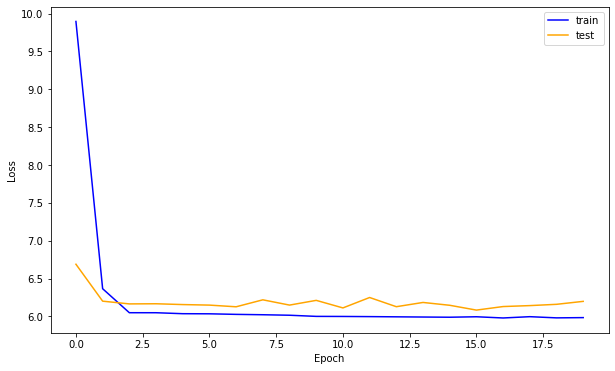

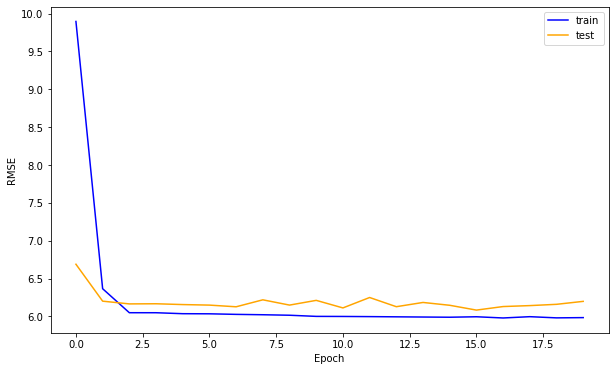

In [432]:
regre4 = buildregre4(128)
#regre3C = buildregre3(1)
RcompareTrainTest(regre4, 20, True);

In [431]:
regre4C = buildregre4(128)
for ii in range(4):
    RTRAIN(ii, regre4C, trainloader)
RTEST(regre4C, valloader)

[EPOCH 0]	[TRAIN LOSS]: 9.861779	[TRAIN RMSE]: 9.861779
[EPOCH 1]	[TRAIN LOSS]: 6.346452	[TRAIN RMSE]: 6.346452
[EPOCH 2]	[TRAIN LOSS]: 6.044826	[TRAIN RMSE]: 6.044826
[EPOCH 3]	[TRAIN LOSS]: 6.039268	[TRAIN RMSE]: 6.039268
[TEST LOSS AVG]: 5.985864	[TEST RMSE AVG]: 5.985864


(5.9858640524057245, 5.985864085069555)

69


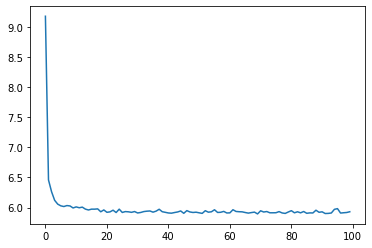

In [234]:
plt.plot(rmse)
print(rmse.index(min(rmse)))

[TEST LOSS AVG]: 5.994236	[TEST RMSE AVG]: 5.994236
[TEST LOSS AVG]: 5.938059	[TEST RMSE AVG]: 5.938059
[TEST LOSS AVG]: 6.158370	[TEST RMSE AVG]: 6.158370
[TEST LOSS AVG]: 5.981757	[TEST RMSE AVG]: 5.981757
[TEST LOSS AVG]: 5.937886	[TEST RMSE AVG]: 5.937886
[TEST LOSS AVG]: 6.072060	[TEST RMSE AVG]: 6.072060
[TEST LOSS AVG]: 6.001964	[TEST RMSE AVG]: 6.001964
[TEST LOSS AVG]: 6.023784	[TEST RMSE AVG]: 6.023784
[TEST LOSS AVG]: 6.047154	[TEST RMSE AVG]: 6.047154
[TEST LOSS AVG]: 6.024112	[TEST RMSE AVG]: 6.024112
[TEST LOSS AVG]: 5.970403	[TEST RMSE AVG]: 5.970403
[TEST LOSS AVG]: 6.018062	[TEST RMSE AVG]: 6.018062
[TEST LOSS AVG]: 6.004765	[TEST RMSE AVG]: 6.004765
[TEST LOSS AVG]: 5.953081	[TEST RMSE AVG]: 5.953081
[TEST LOSS AVG]: 6.017312	[TEST RMSE AVG]: 6.017312
[TEST LOSS AVG]: 5.937705	[TEST RMSE AVG]: 5.937705
[TEST LOSS AVG]: 6.065490	[TEST RMSE AVG]: 6.065490
[TEST LOSS AVG]: 5.978513	[TEST RMSE AVG]: 5.978514
[TEST LOSS AVG]: 6.029115	[TEST RMSE AVG]: 6.029115
[TEST LOSS A

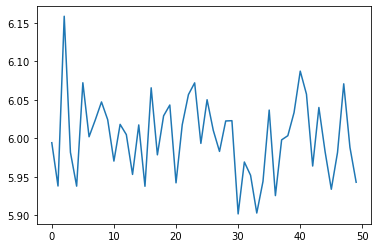

In [241]:

RSrmse = []
for ii in np.random.randint(1,1000, size = 50):
    _,_,valloader = getLoaders(ii)
    RSrmse.append(RTEST(regre4C, valloader)[1])


In [437]:
regre4C = buildregre4(200)
for ii in range(10):
    RTRAIN(ii, regre4C, trainloader)
    RTEST(regre4C, valloader)

[EPOCH 0]	[TRAIN LOSS]: 8.692639	[TRAIN RMSE]: 8.692639
[TEST LOSS AVG]: 6.503532	[TEST RMSE AVG]: 6.503532
[EPOCH 1]	[TRAIN LOSS]: 6.220097	[TRAIN RMSE]: 6.220097
[TEST LOSS AVG]: 6.014614	[TEST RMSE AVG]: 6.014614
[EPOCH 2]	[TRAIN LOSS]: 6.046321	[TRAIN RMSE]: 6.046321
[TEST LOSS AVG]: 5.994968	[TEST RMSE AVG]: 5.994968
[EPOCH 3]	[TRAIN LOSS]: 6.040453	[TRAIN RMSE]: 6.040453
[TEST LOSS AVG]: 6.092912	[TEST RMSE AVG]: 6.092912
[EPOCH 4]	[TRAIN LOSS]: 6.026614	[TRAIN RMSE]: 6.026614
[TEST LOSS AVG]: 5.988486	[TEST RMSE AVG]: 5.988486
[EPOCH 5]	[TRAIN LOSS]: 6.025155	[TRAIN RMSE]: 6.025155
[TEST LOSS AVG]: 5.954568	[TEST RMSE AVG]: 5.954568
[EPOCH 6]	[TRAIN LOSS]: 6.019432	[TRAIN RMSE]: 6.019432
[TEST LOSS AVG]: 6.334162	[TEST RMSE AVG]: 6.334162
[EPOCH 7]	[TRAIN LOSS]: 6.018013	[TRAIN RMSE]: 6.018013
[TEST LOSS AVG]: 6.019957	[TEST RMSE AVG]: 6.019957
[EPOCH 8]	[TRAIN LOSS]: 6.012180	[TRAIN RMSE]: 6.012180
[TEST LOSS AVG]: 5.979551	[TEST RMSE AVG]: 5.979551
[EPOCH 9]	[TRAIN LOSS]: 6.00

0.05162486465557875
6.00164378266784


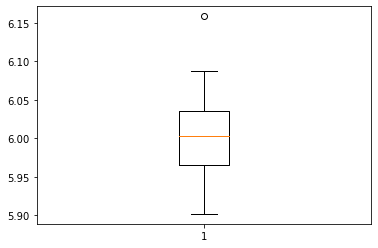

In [243]:

plt.boxplot(RSrmse)
print(np.std(RSrmse))
print(np.mean(RSrmse))

In [228]:
regre4C = buildregre4(h)
rmse = []
for ii in range(20):
    RTRAIN(ii, regre4C, trainloader)
RTEST(regre4C, valloader)

[EPOCH 0]	[TRAIN LOSS]: 17.324164	[TRAIN RMSE]: 17.324164
[EPOCH 1]	[TRAIN LOSS]: 6.659174	[TRAIN RMSE]: 6.659174
[EPOCH 2]	[TRAIN LOSS]: 6.388995	[TRAIN RMSE]: 6.388995
[EPOCH 3]	[TRAIN LOSS]: 6.211037	[TRAIN RMSE]: 6.211037
[EPOCH 4]	[TRAIN LOSS]: 6.125153	[TRAIN RMSE]: 6.125153
[EPOCH 5]	[TRAIN LOSS]: 6.081491	[TRAIN RMSE]: 6.081491
[EPOCH 6]	[TRAIN LOSS]: 6.060020	[TRAIN RMSE]: 6.060020
[EPOCH 7]	[TRAIN LOSS]: 6.044158	[TRAIN RMSE]: 6.044158
[EPOCH 8]	[TRAIN LOSS]: 6.042386	[TRAIN RMSE]: 6.042386
[EPOCH 9]	[TRAIN LOSS]: 6.034081	[TRAIN RMSE]: 6.034081
[EPOCH 10]	[TRAIN LOSS]: 6.029033	[TRAIN RMSE]: 6.029033
[EPOCH 11]	[TRAIN LOSS]: 6.019470	[TRAIN RMSE]: 6.019470
[EPOCH 12]	[TRAIN LOSS]: 6.019147	[TRAIN RMSE]: 6.019147
[EPOCH 13]	[TRAIN LOSS]: 6.003873	[TRAIN RMSE]: 6.003873
[EPOCH 14]	[TRAIN LOSS]: 6.001025	[TRAIN RMSE]: 6.001025
[EPOCH 15]	[TRAIN LOSS]: 5.997859	[TRAIN RMSE]: 5.997859
[EPOCH 16]	[TRAIN LOSS]: 5.992318	[TRAIN RMSE]: 5.992318
[EPOCH 17]	[TRAIN LOSS]: 5.983995	[TRAI

(6.03193763586191, 6.031937638398121)

In [240]:
np.random.randint(1,1000, size = 50)

array([145, 266, 347, 811, 169, 748, 818, 839, 870, 751, 516, 306,  10,
       342, 883, 884, 934, 503, 967, 528, 292, 512, 972, 481, 564, 906,
       830, 693, 712, 878, 336, 495,  63, 979, 902, 283,  66, 325, 101,
       737, 837, 429, 724, 852, 454, 969, 698, 424, 152, 265])

In [353]:
x = torch.tensor([0.5,0.4,0.3,0.6,0.7])
y = torch.tensor([1,0,0,0,1])
(x.round() == y).sum()

tensor(3)

## EC a) Are there any predictors/features that have effectively no impact on the accuracy of these models? If so, please list them and comment briefly on your findings


In [391]:
df = pd.read_csv('diabetes.csv')#.drop('Zodiac', axis = 1)
dfO = df.copy()
def toDummy(df, var):
    df = df.join(pd.get_dummies(df[var], prefix= var)).drop(var, axis = 1)
    return df
df = toDummy(df, 'Zodiac')
df = toDummy(df, 'BiologicalSex')
df = toDummy(df, 'AgeBracket')
df = toDummy(df, 'EducationBracket')
df = toDummy(df, 'IncomeBracket')
hiddensize = 32
def build(N):
    model = nn.Sequential(
                nn.Linear(N, 32),
                nn.ReLU(),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
    )
    return model
trainloader, testloader, valloader = getLoaders(42)

In [384]:
from sklearn.metrics import accuracy_score
def TRAINACC(epoch, model,lossF, train_loader):
    model.train()
    losses = []
    acc = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    for DD in train_loader:
        data, target = DD
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        #data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        '''try:
            auc.append(roc_auc_score(target, output.detach().numpy()))
        except:
            pass'''
        score, predicted = torch.max(output, 1)
        acc.append((target == predicted).sum().float() / len(target))
        loss = lossF(score.unsqueeze(1).type(torch.FloatTensor), target.unsqueeze(1).type(torch.FloatTensor))
        losses.append(loss.item())
        # backward pass through the cross-entropy loss function and the model
        loss.backward()
        
        optimizer.step()
    print('[EPOCH %d]\t[TRAIN LOSS]: %f\t[TRAIN ACC]: %f' % (epoch,np.mean(losses), np.mean(acc)))
    #return np.mean(losses), np.mean(auc)


def TESTACC(model,lossF, train_loader):
    model.eval()
    losses = []
    acc = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)
            # forward pass through the model
            output = model(data)
            # forward pass through the cross-entropy loss function
            '''try:
                auc.append(roc_auc_score(target, output.detach().numpy()))
            except:
                pass'''
            score, predicted = torch.max(output,1)
            acc.append((target == predicted).sum().float() / len(target))
            loss = lossF(score.unsqueeze(1).type(torch.FloatTensor), target.unsqueeze(1).type(torch.FloatTensor))
            losses.append(loss.item())
            # backward pass through the cross-entropy loss function and the model

        print('[TEST LOSS AVG]: %f\t[TEST ACC AVG]: %f' % (np.mean(losses), np.mean(acc)))
    return np.mean(losses), np.mean(acc)


In [385]:
# Permutation importance
importances = pd.DataFrame(columns = ['AUC'])
for ii in dfO.columns[1:]:
    df = df.drop(ii, axis = 1)
    try:
        df = toDummy(df, 'Zodiac')
    except:
        pass
    try:
        df = toDummy(df, 'BiologicalSex')
    except:
        pass
    try:
        df = toDummy(df, 'AgeBracket')
    except:
        pass
    try:
        df = toDummy(df, 'EducationBracket')
    except:
        pass
    try:
        df = toDummy(df, 'IncomeBracket')
    except:
        pass
    N = len(df.columns) - 1
    #model = build(N)
    model = nn.Sequential(
                nn.Linear(N, 32),
                nn.ReLU(),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 2),
                nn.Sigmoid()
    )
    trainloader, testloader, valloader = getLoaders(42)
    df = dfO.copy()

    for jj in range(11):
        TRAINACC(jj, model, bce, trainloader)
    auc = TESTACC(model, bce, valloader)[1]
    importances.loc[ii+'Dropped'] = auc
    
    


[EPOCH 0]	[TRAIN LOSS]: 0.360541	[TRAIN ACC]: 0.825374
[EPOCH 1]	[TRAIN LOSS]: 0.327244	[TRAIN ACC]: 0.840964
[EPOCH 2]	[TRAIN LOSS]: 0.324517	[TRAIN ACC]: 0.827953
[EPOCH 3]	[TRAIN LOSS]: 0.323885	[TRAIN ACC]: 0.817520
[EPOCH 4]	[TRAIN LOSS]: 0.323626	[TRAIN ACC]: 0.813707
[EPOCH 5]	[TRAIN LOSS]: 0.323139	[TRAIN ACC]: 0.806654
[EPOCH 6]	[TRAIN LOSS]: 0.322114	[TRAIN ACC]: 0.806614
[EPOCH 7]	[TRAIN LOSS]: 0.321488	[TRAIN ACC]: 0.795459
[EPOCH 8]	[TRAIN LOSS]: 0.321658	[TRAIN ACC]: 0.794869
[EPOCH 9]	[TRAIN LOSS]: 0.321518	[TRAIN ACC]: 0.796982
[EPOCH 10]	[TRAIN LOSS]: 0.321369	[TRAIN ACC]: 0.784587
[TEST LOSS AVG]: 0.315825	[TEST ACC AVG]: 0.819684
[EPOCH 0]	[TRAIN LOSS]: 0.379055	[TRAIN ACC]: 0.194580
[EPOCH 1]	[TRAIN LOSS]: 0.327154	[TRAIN ACC]: 0.152592
[EPOCH 2]	[TRAIN LOSS]: 0.324141	[TRAIN ACC]: 0.157428
[EPOCH 3]	[TRAIN LOSS]: 0.322865	[TRAIN ACC]: 0.162651
[EPOCH 4]	[TRAIN LOSS]: 0.323225	[TRAIN ACC]: 0.165846
[EPOCH 5]	[TRAIN LOSS]: 0.322085	[TRAIN ACC]: 0.171522
[EPOCH 6]	[TR

In [386]:
importances.sort_values('AUC', ascending=False)

,AUC
FruitDropped,0.842963
ZodiacDropped,0.835806
EducationBracketDropped,0.831941
HighBPDropped,0.819684
AgeBracketDropped,0.814736
HeavyDrinkerDropped,0.813105
BMIDropped,0.807909
BiologicalSexDropped,0.806964
VegetablesDropped,0.792872
HasHealthcareDropped,0.790403
